In [ ]:
# CS 531 Spring 2020
# Author: Alina Ene (aene@bu.edu)

# Applications in statistics and machine learning

Least squares, least absolute shrinkage and selection operator (LASSO)

We will be using cvxpy to solve the LASSO optimization. The default solver for cvxpy is numerically unstable, so we will use the CVXOPT solver instead. We can specify the solver to cvxpy as follows:

$\texttt{prob.solve(solver=CVXOPT)}$

If you are running this notebook on your machine, you will need to install cvxpy and cvxopt. You can install them using conda as follows:

$\texttt{conda install -c cvxgrp cvxpy libgcc}$

$\texttt{conda install -c anaconda cvxopt}$

In [41]:
import cvxpy as cvx
import numpy as np
from numpy import linalg
from cvxpy import *
import matplotlib.pyplot as plt

## Least squares
Recall that, in the least squares problem, we are given $A \in \mathbb{R}^{m \times n}$, $b \in \mathbb{R}^m$, and the goal is to solve the problem
$$
\min_{x \in \mathbb{R}^n} \|Ax - b\|^2 = \min_{x \in \mathbb{R}^n} \sum_{i = 1}^m (a_i^T x - b_i)^2 
$$
where $a_i^T$ is the $i$-th row of $A$.

In [42]:
# generate a random instance
def random_instance(m, n):
    A = np.random.randn(m,n)
    b = np.random.randn(m,1)
    return (A, b)

In [43]:
# solve a least squares instance using CVX
def solve_least_squares(A, b):
    x = cvx.Variable(len(A[0]))
    obj = cvx.Minimize(cvx.norm(A*x - b))
    prob = cvx.Problem(obj)
    prob.solve(solver=CVXOPT)
    return (prob.value, x, prob.status)

In [44]:
# run least squares on a random instance
(A, b) = random_instance(16, 8)
(value, x, status) = solve_least_squares(A, b)

print("status:", status)
print("optimal value", value)
print("optimal var", x.value)

status: optimal
optimal value 3.4295091476370145
optimal var [[ 0.12187844]
 [-0.1258244 ]
 [ 0.0444059 ]
 [ 0.20489149]
 [ 0.30398088]
 [-0.19723836]
 [ 0.20083373]
 [ 0.52730448]]


## LASSO
In the LASSO problem, we are solving a variation of the least squares problem where the objective has an additional term that encourages the solution to be sparse (have a small number of non-zeros).
$$
    \min_{x \in \mathbb{R}^n} \|Ax - b\|^2 + \gamma \cdot \|x\|^2_1
$$
$\gamma > 0$ is a positive value that we choose (more on how to set $\gamma$ later).

In [45]:
# solve a LASSO instance using CVX
def solve_lasso(A, b, gamma_value):
    gamma = cvx.Parameter(sign="positive", value=gamma_value)
    x = cvx.Variable(len(A[0]))
    obj = cvx.Minimize((cvx.norm(A*x - b))**2+gamma*(cvx.norm(x,1))**2)
    prob = cvx.Problem(obj)
    prob.solve(solver=CVXOPT)  
    return (prob.value, x, prob.status)

In [46]:
# run lasso on a random instance
(A, b) = random_instance(16, 8)
(value, x, status) = solve_lasso(A, b, 0.1)

print("status:", status)
print("optimal value", value)
print("optimal var", x.value)

status: optimal
optimal value 4.854015704236237
optimal var [[-0.47171799]
 [ 0.00927019]
 [-0.02328763]
 [ 0.63281547]
 [ 0.01590656]
 [-0.6108903 ]
 [-0.39388531]
 [-0.05401183]]


Let us now consider varying $\gamma$ and see what happens to the least squares error term $\|Ax - b\|^2$ and the number of non-zeros. Given the LASSO solution $x$, we will threshold down to $0$ all of the entries of $x$ that are at most $0.1$.

In [47]:
def gamma_range(start, end, step):
    gamma = start
    while gamma < end:
        yield gamma
        gamma += step

# set each entry of x that is smaller than 0.1 to 0
def round_down(x):
    x_rounded = [0 for i in range(len(x))]
    x_nonzeros = 0
    for i in range(len(x)):
        if (float(x[i]) < 0.1):
            x_rounded[i] = 0.0
        else:
            x_rounded[i] = float(x[i])
            x_nonzeros += 1

    return (x_rounded, x_nonzeros)

# returns the ell_2 norm squared of Ax - b
def least_squares_evaluate(A, x, b):
    m = len(A)
    n = len(A[0])
    Ax = [0.0 for i in range(m)]
    for i in range(m):
        for j in range(n):
            Ax[i] += (float(A[i][j]) * float(x[j]))
    z = [0.0 for i in range(m)]
    for i in range(m):
        z[i] = Ax[i] - b[i]
    value = 0.0
    for i in range(m):
        value += (float(z[i]) * float(z[i]))
    return value

In [48]:
# solve the LASSO instances for varying gamma

(A, b) = random_instance(16, 8) 

gamma_values = [x for x in gamma_range(0.1, 2.0, 0.1)]
error_values = [0.0 for x in range(len(gamma_values))]
num_nonzeros = [0 for x in range(len(gamma_values))]

for i in range(len(gamma_values)):
    (value, x, status) = solve_lasso(A, b, gamma_values[i])
    (xnew, nnz) = round_down(x.value)
    error_values[i] = least_squares_evaluate(A, xnew, b)
    num_nonzeros[i] = nnz

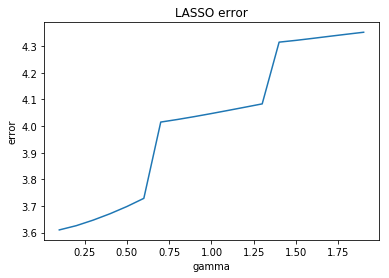

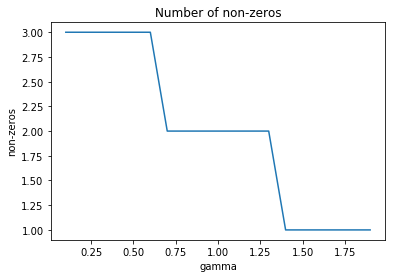

In [49]:
# plot the results

plt.figure()
plt.plot(gamma_values, error_values)
plt.title("LASSO error")
plt.xlabel("gamma")
plt.ylabel("error")
plt.show()

plt.figure()
plt.plot(gamma_values, num_nonzeros)
plt.title("Number of non-zeros")
plt.xlabel("gamma")
plt.ylabel("non-zeros")
plt.show()